In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models
from tensorflow.keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from google.colab import files

from sklearn.feature_selection import mutual_info_classif as MIC

# Install Required Packages

In [2]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 140 kB 47.0 MB/s 
     |████████████████████████████████| 180 kB 45.8 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bd5a102af6f097e14a066f4535f09c6af4d5ed032219e91704c25860f739332b
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=425480fd1bdaca91d67be145bda7be83c7289de3bcc097948637234ea852dd51
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [3]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 5.4 MB/s 


In [4]:
!pip install dataframe-image

     |████████████████████████████████| 1.1 MB 4.4 MB/s 
     |████████████████████████████████| 271 kB 25.4 MB/s 
     |████████████████████████████████| 192 kB 16.4 MB/s 
     |████████████████████████████████| 160 kB 33.4 MB/s 


In [5]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 94.0 MB of archives.
After this operation, 324 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 95.0.4638.69-0ubuntu0.18.04.1 [1,135 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 95.0.4638.69-0ubuntu0.18.04.1 [83.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 95.0.4638.69-0ubuntu0.18.0

In [6]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Get and Prepare Dataset

In [7]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project/Data/emotions.csv")
print(data.info())
# !ls "/content/drive/My Drive/Colab Notebooks/Project/Data"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [10]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.70,27.9,3.170,32.2,-368.0,15.90,36.4,7.08,28.8,-359.0,17.30,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.600,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.00,-185.00,-185.00,374.00,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.20,32.9,31.800,33.1,33.2,28.50,26.8,32.40,34.7,33.8,27.00,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.530,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.00,40.70,40.70,-19.00,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.40,20.0,79.800,31.0,-408.0,91.90,29.5,18.80,31.1,-335.0,32.20,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.000,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.00,-48.80,-48.80,159.00,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.90,27.7,15.700,30.7,-142.0,20.70,22.8,13.60,32.2,-135.0,21.20,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.830,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.90,-5.08,-5.08,-61.90,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.00,22.9,59.400,26.7,60.3,64.70,26.9,32.30,30.1,33.6,31.60,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.600,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.90,-7.25,-7.25,15.90,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,33.30,33.4,31.0,32.30,18.6,30.00,33.0,32.6,29.50,29.1,32.000,29.9,32.6,28.50,24.9,34.50,32.4,32.4,33.00,20.8,3.3500,0.461,-1.61000,2.880,-10.60,1.31,3.490,-1.540,3.860

In [11]:
data.isnull().sum().sum()

0

In [12]:
# View a sample of time series data
sample = data.loc[5, 'fft_0_a':'fft_479_a']
sample

fft_0_a       203
fft_1_a        -1
fft_2_a     -7.16
fft_3_a     -7.16
fft_4_a        -1
             ... 
fft_475_a     131
fft_476_a    4.73
fft_477_a   -15.5
fft_478_a   -15.5
fft_479_a    4.73
Name: 5, Length: 480, dtype: object

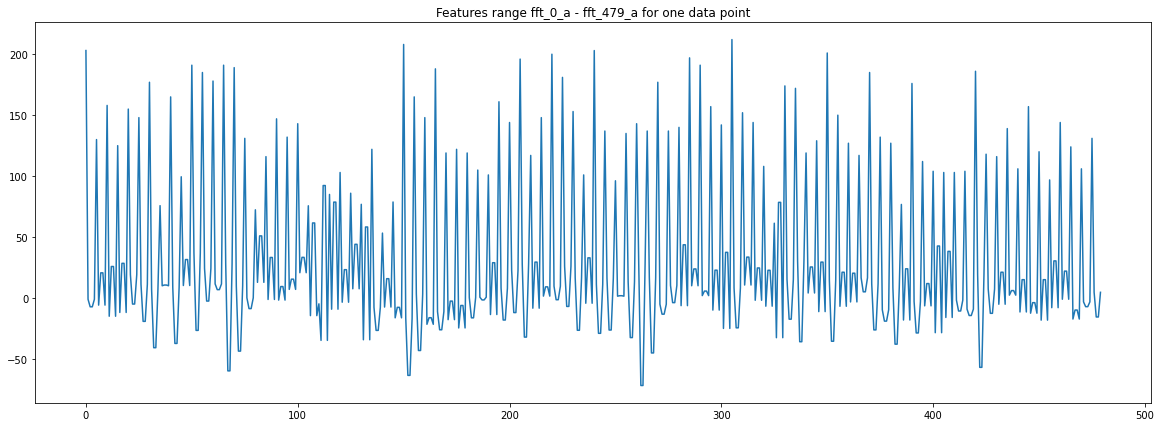

In [13]:
# from google.colab import files

plt.figure(figsize=(20,7))
plt.plot(range(len(sample)), sample)
plt.title('Features range fft_0_a - fft_479_a for one data point')
# plt.savefig('sample_data.png')
# files.download('sample_data.png')
plt.show()

In [14]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

# Data Preprocessing

In [15]:
## Data Preprocessing
label_mapping = {'Negative':0, 'NEUTRAL':1, 'POSITIVE':2}

In [16]:
# Scaling the dataset
y = data.pop('label').astype('category').cat.codes
X = data                                              # do not change original dataset

In [17]:
# Identifying the top features related to our dataset
mi_score = MIC(X, y)  # mutual_info_classif helps us for defining the % of dependence between features and target variables.

In [18]:
mi_score

array([0.52560259, 0.25252577, 0.72839325, ..., 0.20789903, 0.20847314,
       0.40378969])

In [19]:
mi_score = pd.Series(mi_score, index=X.columns)
mi_score = (mi_score*100).sort_values(ascending=False)

In [20]:
# mi_score_index = np.where(mi_score>40)[0]
# mi_score_index

In [21]:
# Select features with more than 10% MI-score
top_features1 = mi_score[:-364].index # 2184. 10% MI-score
top_features2 = mi_score[:-552].index # 1996. 20% MI-score
top_features3 = mi_score[:-1095].index # 1453. 30% MI-score
top_features4 = mi_score[:-1960].index # 588. 40% MI-score

In [23]:
top_features1

Index(['covmat_0_a', 'covmat_0_b', 'mean_2_b', 'mean_2_a', 'mean_d_12_a',
       'mean_d_2_b2', 'covmat_4_a', 'covmat_4_b', 'mean_d_2_a2', 'covmat_48_b',
       ...
       'covmat_42_a', 'covmat_46_a', 'logm_54_b', 'logm_50_b', 'logm_60_a',
       'covmat_42_b', 'logm_60_b', 'covmat_83_a', 'covmat_138_a',
       'covmat_135_b'],
      dtype='object', length=2184)

In [25]:
# scaled_data = StandardScaler().fit_transform(X) # not applied feature selection
scaled_data = StandardScaler().fit_transform(X[top_features1]) # applied feature selection

In [26]:
# Split dataset into training set and test set (80:20)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, random_state=42, test_size=0.2, stratify=y)  # random_state: make sure to have same result

In [27]:
print("Training set:",len(X_train), "Test set:", len(X_test))

Training set: 1705 Test set: 427


In [28]:
y_train.value_counts()

1    573
2    566
0    566
dtype: int64

In [29]:
y_test.value_counts()

1    143
2    142
0    142
dtype: int64

# Define the Model

Here, we define CNN (with convolution, batch normalization, max-pooling and dropout) in Keras.

In [38]:
# model = models.Sequential()
# model.add(layers.Conv1D(64,10, input_shape=(X_train.shape[1],1)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPool1D(2))
# model.add(layers.Dropout(0.25))

# model.add(layers.Conv1D(64,5))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPool1D(2))
# model.add(layers.Dropout(0.25))

# model.add(layers.Flatten())
# model.add(layers.Dense(3, activation='softmax'))

# model.summary()

def Model(filters1, filters2, kernel_size1, kernel_size2, dropout1, dropout2):

  # inputs = keras.layers.Input(shape=(X_train.shape[1],1))

  # x = keras.layers.Conv1D(filters=filters1, kernel_size=kernel_size1)(inputs)
  # x = keras.layers.BatchNormalization(x)
  # x = keras.layers.ReLU(x)
  # x = keras.layers.MaxPooling1D(pool_size=2)(x)
  # x = keras.layers.Dropout(dropout1)(x)

  # x = keras.layers.Conv1D(filters=filters2, kernel_size=kernel_size2)(x)
  # x = keras.layers.BatchNormalization(x)
  # x = keras.layers.ReLU(x)
  # x = keras.layers.MaxPooling1D(pool_size=2)(x)
  # x = keras.layers.Dropout(dropout2)(x)

  # x = keras.layers.Flatten(x)
  # outputs = keras.layers.Dense(3, activation='softmax')(x)

  model = models.Sequential()
  model.add(layers.Conv1D(filters1, kernel_size1, input_shape=(X_train.shape[1], 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool1D(2))
  model.add(layers.Dropout(dropout1))

  model.add(layers.Conv1D(filters2, kernel_size2))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool1D(2))
  model.add(layers.Dropout(dropout2))

  model.add(layers.Flatten())
  model.add(layers.Dense(3, activation='softmax'))

  return model

# Train the Model

Train the model with Wandb

In [39]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # As Ys(labels) are integers, we use sparse categorical crossentropy.
#                                                                                               # Whereas we use categorical crossentropy when Ys are one-hot encoded.
# # call = callbacks.EarlyStopping(patience=10, min_delta=0.0001, restore_best_weights=True)
# history=model.fit(X_train, y_train, validation_split=0.25, batch_size=28, epochs=10, shuffle=True)

# Initialize wandb with your project name
run = wandb.init(project='eeg-emotional-classification',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 30,
                     "batch_size": 28,
                     "loss_function": "sparse_categorical_crossentropy",
                     "filters1": 64,
                     "filters2": 64,
                     "kernel_size1": 5,
                     "kernel_size2" : 5,
                     "dropout1": 0.5,
                     "dropout2": 0.5
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model(config.filters1, config.filters2, config.kernel_size1, config.kernel_size2, config.dropout1, config.dropout2)
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2180, 64)          384       
                                                                 
 batch_normalization (BatchN  (None, 2180, 64)         256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 2180, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1090, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1090, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1086, 64)          2

In [32]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
files.download('model.png')
# import visualkeras
# visualkeras.layered_view(model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# We train with our beloved model.fit
# Notice WandbCallback is used as a regular callback
# We again use config
history = model.fit(X_train, y_train,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_split=0.25,
          shuffle=True,
          callbacks=[WandbCallback()])

Epoch 1/30
46/46 [==============================] - 3s 35ms/step - loss: 0.9710 - accuracy: 0.8052 - val_loss: 0.5698 - val_accuracy: 0.8548
Epoch 2/30
46/46 [==============================] - 1s 28ms/step - loss: 0.8108 - accuracy: 0.8670 - val_loss: 2.1331 - val_accuracy: 0.3958
Epoch 3/30
46/46 [==============================] - 1s 27ms/step - loss: 0.4280 - accuracy: 0.9092 - val_loss: 0.6159 - val_accuracy: 0.7799
Epoch 4/30
46/46 [==============================] - 1s 26ms/step - loss: 0.3866 - accuracy: 0.9108 - val_loss: 2.0095 - val_accuracy: 0.4871
Epoch 5/30
46/46 [==============================] - 1s 27ms/step - loss: 0.5302 - accuracy: 0.9139 - val_loss: 0.5771 - val_accuracy: 0.9251
Epoch 6/30
46/46 [==============================] - 1s 27ms/step - loss: 0.1839 - accuracy: 0.9554 - val_loss: 0.2957 - val_accuracy: 0.9344
Epoch 7/30
46/46 [==============================] - 1s 26ms/step - loss: 0.3079 - accuracy: 0.9429 - val_loss: 0.4526 - val_accuracy: 0.9415
Epoch 8/30
46

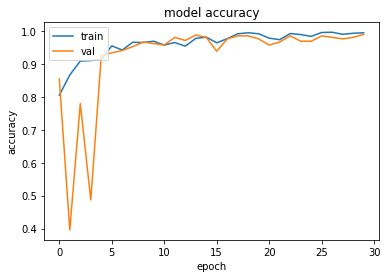

In [41]:
# summarize history for accuracy
from google.colab import files

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model.png')
# files.download('model.png')
plt.show()

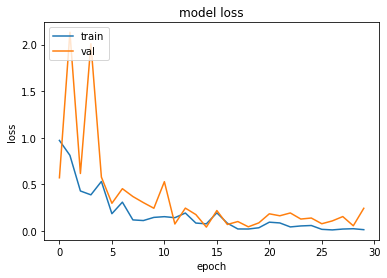

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Time to evaluate the model with test set!

Here, we log the test accuracy.

In [43]:
loss, accuracy = model.evaluate(X_test, y_test)

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Accuracy': accuracy})

run.finish()

14/14 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.9813


Test Accuracy,▁
accuracy,▁▃▅▅▅▆▆▇▇▇▇▇▆▇▇▇▇███▇▇████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▄▄▅▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁
val_accuracy,▆▁▆▂▇▇▇████████▇██████████████
val_loss,▃█▃█▃▂▂▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
Test Accuracy,0.98126
accuracy,0.99531
best_epoch,14
best_val_loss,0.04004
epoch,29


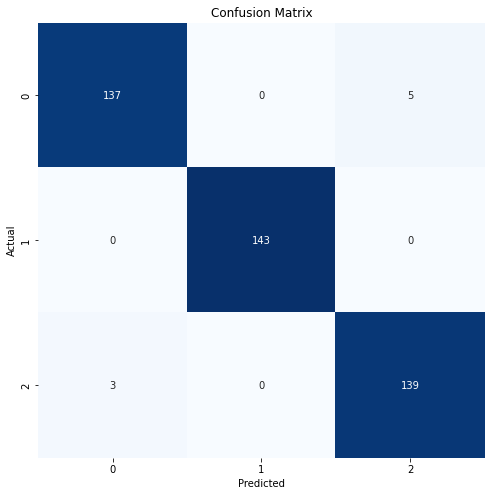

Classifcation Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       142
           1       1.00      1.00      1.00       143
           2       0.97      0.98      0.97       142

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



In [44]:
# Confusion matrix and Classification report

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Classifcation Report:\n', clr)